In [151]:
# install libraries

import numpy as np # for working with arrays
import pandas as pd # for working with data set, data frame structure
import yfinance as yf # for using Yahoo finance API
import matplotlib.pyplot as plt # for data visualization

# build and train everything with the neural network
import torch 
import torch.nn as nn
import torch.optim as optim


from sklearn.preprocessing import StandardScaler # for scaling data
from sklearn.metrics import root_mean_squared_error # for evaluating our model

# run this if you have any import errors
# import sys
# print(sys.executable)
# then in your terminal run /path/to/python -m pip install {module}
print("Libraries successfully installed")

Libraries successfully installed


In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU for processing large tensors and matrix operations if available
device

device(type='cpu')

In [153]:
# A ticker (short for ticker symbol) is a unique series of letters assigned to a publicly traded company's stock for identification on a stock exchange

ticker = 'AAPL' # ticker for Apple

# uses the yfinance library to download historical stock price data for Apple Inc. starting from January 1, 2024 up to the current date
df = yf.download(ticker, '2020-01-01')
df

/var/folders/qy/c074xc497m3gm7r7q1b3qyvm0000gn/T/ipykernel_78339/3191595310.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620850,72.681296,71.373226,71.627100,135480400
2020-01-03,71.914825,72.676454,71.689965,71.847125,146322800
2020-01-06,72.487862,72.526549,70.783263,71.034724,118387200
2020-01-07,72.146935,72.753816,71.926907,72.497522,108872000
2020-01-08,73.307526,73.609760,71.849548,71.849548,132079200
...,...,...,...,...,...
2025-07-18,211.179993,211.789993,209.699997,210.869995,48974600
2025-07-21,212.479996,215.779999,211.630005,212.100006,51377400


<Axes: xlabel='Date'>

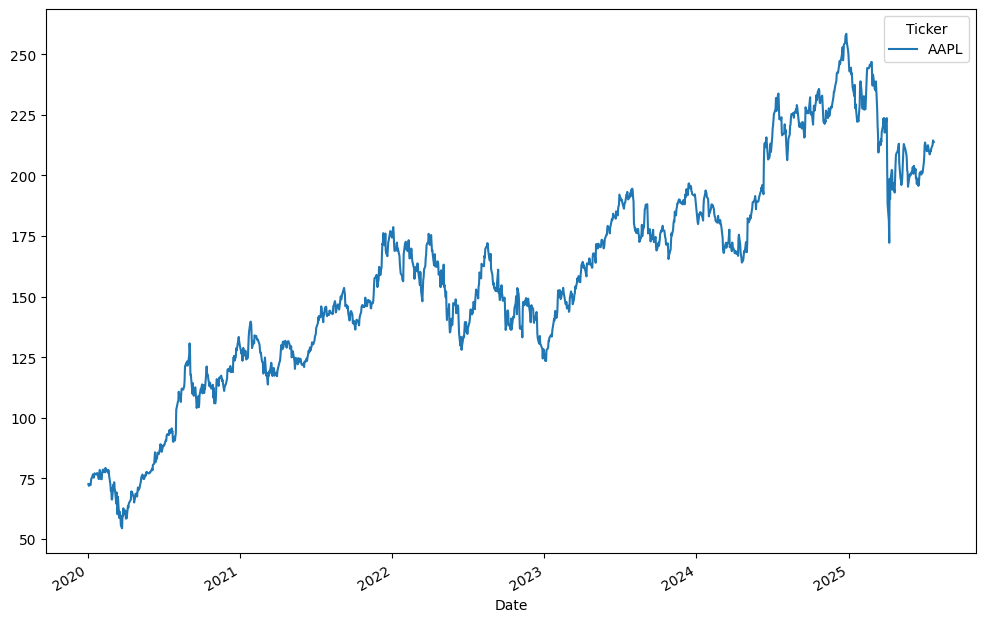

In [154]:
# visually plot the data
df.Close.plot(figsize=(12, 8))

In [155]:
scaler = StandardScaler()

# scale all of the data to fit distribution
df['Close'] = scaler.fit_transform(df['Close'])
df.Close # produce the close values in a normal distribution with the mean of 0 and a standard deviation of 1

Ticker,AAPL
Date,
2020-01-02,-1.926390
2020-01-03,-1.942261
2020-01-06,-1.929379
2020-01-07,-1.937043
2020-01-08,-1.910954
...,...
2025-07-18,1.188287
2025-07-21,1.217509
2025-07-22,1.260669


In [156]:
# prepare the data for out neural network
# we want at any point and time to look at the past x days, where x is some arbitrary integer, and predict what the stock price will be for the next day (next data point)

seq_length = 30 # how many days we would like to consider
data = []

# look at the first 29th days and then try to predict the 30th day
for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length]) # have overlap bc if we want to keep predicting the next day (look at visual)

data = np.array(data)
data

array([[[-1.92638993],
        [-1.94226068],
        [-1.92937937],
        ...,
        [-1.81758666],
        [-1.77623542],
        [-1.78892996]],

       [[-1.94226068],
        [-1.92937937],
        [-1.93704309],
        ...,
        [-1.77623542],
        [-1.78892996],
        [-1.78849366]],

       [[-1.92937937],
        [-1.93704309],
        [-1.91095411],
        ...,
        [-1.78892996],
        [-1.78849366],
        [-1.82091035]],

       ...,

       [[ 1.02508892],
        [ 0.96956566],
        [ 0.99699012],
        ...,
        [ 1.16221121],
        [ 1.18828663],
        [ 1.21750945]],

       [[ 0.96956566],
        [ 0.99699012],
        [ 0.90954667],
        ...,
        [ 1.18828663],
        [ 1.21750945],
        [ 1.26066917]],

       [[ 0.99699012],
        [ 0.90954667],
        [ 0.91898782],
        ...,
        [ 1.21750945],
        [ 1.26066917],
        [ 1.25504941]]], shape=(1367, 30, 1))

In [157]:
# train the first 80% of the data (use for input) for sequential predicting
train_size = int(0.8 * len(data)) 

X_train = torch.tensor(data[:train_size, :-1, :]).type(torch.Tensor).to(device) # 1st dimension (outter most), 2nd dimension, 3rd dimension (inner most) respectively (29 days)
y_train = torch.tensor(data[:train_size, -1, :]).type(torch.Tensor).to(device) #  remove colon in 2nd dimension bc only interested in the last element (30th day)
X_test = torch.tensor(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.tensor(data[train_size:, -1, :]).type(torch.Tensor).to(device)

# Note:
# torch.from_numpy() -	Creates a view of the NumPy array (shares memory)
# torch.tensor() - Creates a copy of the data (no memory sharing) --> .from_numpy() was giving me trouble so I use this instead

In [158]:
X_train


tensor([[[-1.9264],
         [-1.9423],
         [-1.9294],
         ...,
         [-1.8070],
         [-1.8176],
         [-1.7762]],

        [[-1.9423],
         [-1.9294],
         [-1.9370],
         ...,
         [-1.8176],
         [-1.7762],
         [-1.7889]],

        [[-1.9294],
         [-1.9370],
         [-1.9110],
         ...,
         [-1.7762],
         [-1.7889],
         [-1.7885]],

        ...,

        [[ 0.3074],
         [ 0.5386],
         [ 0.5013],
         ...,
         [ 0.7621],
         [ 1.0760],
         [ 1.2085]],

        [[ 0.5386],
         [ 0.5013],
         [ 0.5167],
         ...,
         [ 1.0760],
         [ 1.2085],
         [ 1.2347]],

        [[ 0.5013],
         [ 0.5167],
         [ 0.5243],
         ...,
         [ 1.2085],
         [ 1.2347],
         [ 1.1955]]])

In [159]:
y_train

tensor([[-1.7889],
        [-1.7885],
        [-1.8209],
        ...,
        [ 1.2347],
        [ 1.1955],
        [ 1.2890]])

In [160]:
# create a new neural network class called PredictModel, which inherits from nn.Module, the base class for all neural networks in PyTorch.

class PredictModel(nn.Module):

    # constructor
    # input_dim: Number of features at each time step.
    # hidden_dim: Number of features in the LSTM's hidden state.
    # num_layers: Number of stacked LSTM layers.
    # output_dim: Number of output features (e.g., 1 for predicting a single value).
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        # call the parent constructor so PyTorch can manage your model correctly.
        super(PredictModel, self).__init__()

        # the LSTM parameters to use later when creating the hidden state.
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # initialize an LSTM layer.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) # batch_first=True means input shape should be (batch_size, seq_len, input_dim).
        self.fc = nn.Linear(hidden_dim, output_dim) # Adds a fully connected layer that maps from LSTM's hidden output to your desired output size (e.g., one prediction per sequence).

    # this function defines how the model processes input x and generates output (i.e., prediction).
    def forward(self, x):
        # initialize the hidden state (h0) and cell state (c0) with zeros.
        # Shape explanation: (num_layers, batch_size, hidden_dim)
        # device=device puts the tensors on GPU if available.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        # feed input x into the LSTM.
        # (h0, c0) are the initial states. Using .detach() avoids tracking gradients through them.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) # hn, cn are the final hidden and cell states.
        out = self.fc(out[:, -1, :]) # contains the LSTM output at each time step.

        return out

In [161]:
model = PredictModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)
# .to(device) moves the model to CPU or GPU depending on your setting.

In [162]:
# use Mean Squared Error as the loss — typical for regression problems.
criterion = nn.MSELoss()

# set up the Adam optimizer with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [163]:
num_epochs = 200

for i in range(num_epochs):
    # call the model on training input to get predicted output.
    y_train_pred = model(X_train)

    # calculate how far off the predictions are from the actual target (y_train).
    loss = criterion(y_train_pred, y_train)

    # Prints the loss every 25 epochs to monitor progress.
    if i % 25 == 0:
        print(i, loss.item())

    optimizer.zero_grad() # reset gradients from the previous step (they accumulate otherwise).
    loss.backward() # compute the gradients via backpropagation.
    optimizer.step() # update the model's weights using the optimizer and the gradients.

# Note: backpropagation is like telling the model: "Hey, here's how much you messed up. Now adjust your internal dials (weights) slightly so you make fewer mistakes next time."

0 0.7012070417404175
25 0.009817794896662235
50 0.00663832388818264
75 0.005925985984504223
100 0.005477639380842447
125 0.005073619075119495
150 0.004685314372181892
175 0.0043252138420939445


In [164]:
# visualize how well the model performs on unseen data

model.eval()

y_train_pred = model(X_train)
y_test_pred = model(X_test)

# My architectire doesn't support this
# y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
# y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
# y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
# y_test= scaler.inverse_transform(y_test.detach().cpu().numpy())

# do inverse mannually
# want to take all the y_train and y_test data and perform an inverse transform with a scaler
# then take the scaled data and inverse scale it back to actual price
# then detach and take it to the CPU, convert it into numpy array, then calculate the RMSE (Root Mean Squared Error) for the numpy arrays
# but in this case, I want to make sure everything is done using pure PyTorch tensors on the appropriate device (CPU or GPU).

# Convert mean and std from scaler to PyTorch tensors
mean = torch.tensor(scaler.mean_, dtype=torch.float32, device=device)
std = torch.tensor(scaler.scale_, dtype=torch.float32, device=device)

# Reshape for broadcasting (1, 1) because we are doing (batch_size, 1) * (1, 1)
mean = mean.view(1, 1)
std = std.view(1, 1)

# Inverse transform: undo standardization
y_train_pred_inv = y_train_pred * std + mean
y_train_inv = y_train * std + mean
y_test_pred_inv = y_test_pred * std + mean
y_test_inv = y_test * std + mean

In [165]:
# calculate the train and test Root Mean Squared Error 

def manual_rmse(y_true, y_pred):
    # Ensure both tensors are on the same device
    diff = y_pred - y_true  # difference between predictions and actuals
    squared_diff = diff ** 2  # square the differences
    mean_squared_error = torch.mean(squared_diff)  # take the average
    rmse = torch.sqrt(mean_squared_error)  # square root of the average
    return rmse


train_rmse = manual_rmse(y_train[:,0], y_train_pred[:,0]) * 100
test_rmse = manual_rmse(y_test[:,0], y_test_pred[:,0]) * 100

In [166]:
train_rmse.item()

6.330295562744141

In [167]:
test_rmse.item()

10.989253997802734

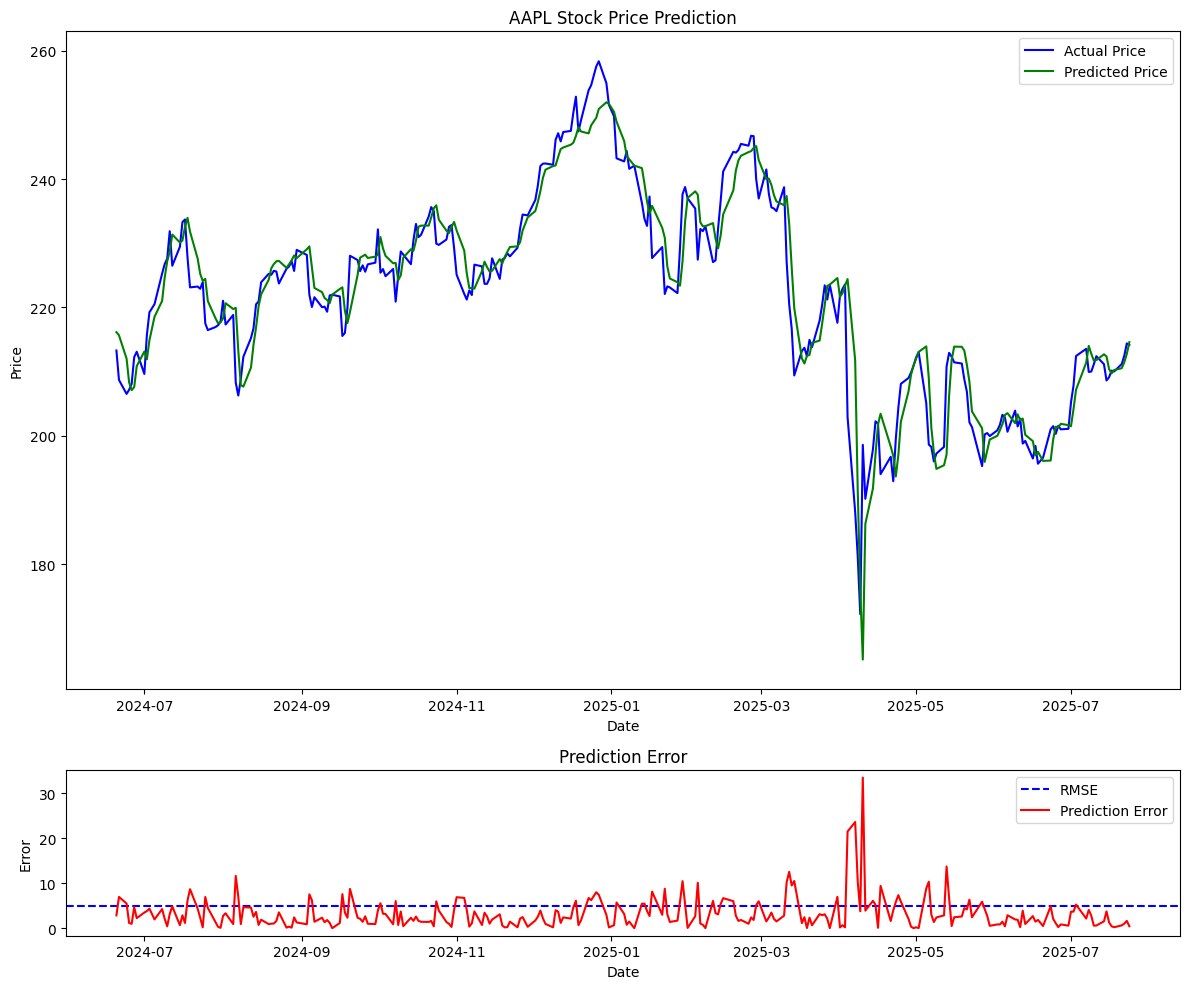

In [168]:
# visualize and plot the following:
# 1. 3/4 of the plot with a price and the prediction
# 2. below that visualize the error
# 3. for each point and time how large the error is
# 4. the rmse

# Ensure all tensors are on CPU and converted to NumPy for matplotlib
# Move to CPU and convert to flat Python lists
y_test_list = y_test_inv.detach().cpu().flatten().tolist()
y_test_pred_list = y_test_pred_inv.detach().cpu().flatten().tolist()

# Compute absolute error as list
error_list = [abs(a - b) for a, b in zip(y_test_list, y_test_pred_list)]

# Compute RMSE manually
squared_errors = [(a - b) ** 2 for a, b in zip(y_test_list, y_test_pred_list)]
test_rmse = (sum(squared_errors) / len(squared_errors)) ** 0.5

fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 1) # 4 rows, 1 column

# Plot actual vs predicted prices
axis1 = fig.add_subplot(gs[:3, 0]) # fill the first 3 rows and the first column
axis1.plot(df.iloc[-len(y_test_list):].index, y_test_list, color='blue', label='Actual Price') # plot from the beginning of the test set until all the data at the end. y_test will be the actual price data for the stock
axis1.plot(df.iloc[-len(y_test_list):].index, y_test_pred_list, color='green', label='Predicted Price')
axis1.legend()
axis1.set_title(f'{ticker} Stock Price Prediction')
axis1.set_xlabel('Date')
axis1.set_ylabel('Price')

# Plot prediction error
axis2 = fig.add_subplot(gs[3, 0])
axis2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
axis2.plot(df.iloc[-len(error_list):].index, error_list, color='red', label='Prediction Error')
axis2.legend()
axis2.set_title('Prediction Error')
axis2.set_xlabel('Date')
axis2.set_ylabel('Error')

plt.tight_layout()
plt.show()

# NOTE: THIS MODEL IS NOT TOTALLY ACCURATE (AND KINDA BAD)

## Remember that this model always look at the past 29 days to predict the next day
## Even where it looks like the model made a good prediction, it's always shifted to the right
## This means that whenever the model realizes that something is about to change in trend, it's essentially after it already happened

# To Improve:

## 1. Use More Context (or Better Features)
<!-- Instead of just using raw prices for 29 days, engineer better input features:

Returns: Percent change in price ((price_t - price_{t-1}) / price_{t-1})

Rolling indicators: Moving averages, volatility (std dev), RSI, momentum, etc.

Volume: Trading volume or volume change can hint at breakout moves.

→ This gives the model more insight into how fast or how likely a change is coming. -->

## 2. Model Architecture Improvements
<!-- If you’re using a simple LSTM or GRU:

Try Bidirectional LSTMs (BiLSTM): They see forward and backward context — although this isn’t practical for real-time prediction, it’s great for analysis.

Add attention mechanisms: These help the model focus on relevant time steps instead of treating all 29 days equally.

Switch to a Transformer-based model: Like Informer, Autoformer, or TimesNet. They can capture both long-term dependencies and abrupt trend changes better. -->

## 3. Change Windowing Strategy

## 4. Normalize Differently
<!-- Sometimes using StandardScaler on raw prices results in loss of trend clarity. Try:

MinMaxScaler

Z-score based on rolling window

Or normalize based on percent change instead of absolute value. -->

## 5. Use Lag Features or Deltas
<!-- Create additional features like:

Price deltas: price_t - price_{t-1}

Lag features: Include day-1, day-2, ... day-5 prices as separate columns

This makes trend changes more detectable. -->

## 6. Regularization and Training Improvements
<!-- Make sure you’re not overfitting (check validation loss vs training loss).

Use dropout, early stopping, or weight decay.

Try longer training time with learning rate decay. -->